<a href="https://colab.research.google.com/github/No1Talent/DLSelfDrivingCars/blob/master/Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets # handling deep learning models, image transformations, and datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Data Prep

Initial Import

```
# download and unzip
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
!unzip data.zip
%ls

# remove unnecessary
!rm data.zip
!rm -r __MACOSX

# save data to MyDrive
from google.colab import drive
drive.mount('/content/drive')
!mv data "/content/drive/MyDrive/"
```


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/')

%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive'

In [11]:
import csv

from torch.utils.data import random_split

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

# Split the data into training and validation sets
train_len = int(0.8 * len(samples))
train_samples, validation_samples = random_split(samples, [train_len, len(samples) - train_len])

In [12]:
# samples.head
len(samples), samples[:1]

(8036,
 [['IMG/center_2016_12_01_13_30_48_287.jpg',
   ' IMG/left_2016_12_01_13_30_48_287.jpg',
   ' IMG/right_2016_12_01_13_30_48_287.jpg',
   ' 0',
   ' 0',
   ' 0',
   ' 22.14829']])

# Data Viz

In [14]:
dir = "data/"
data = pd.read_csv('data/driving_log.csv')
data.head()
# data.iloc[1]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


<Axes: xlabel='steering', ylabel='Count'>

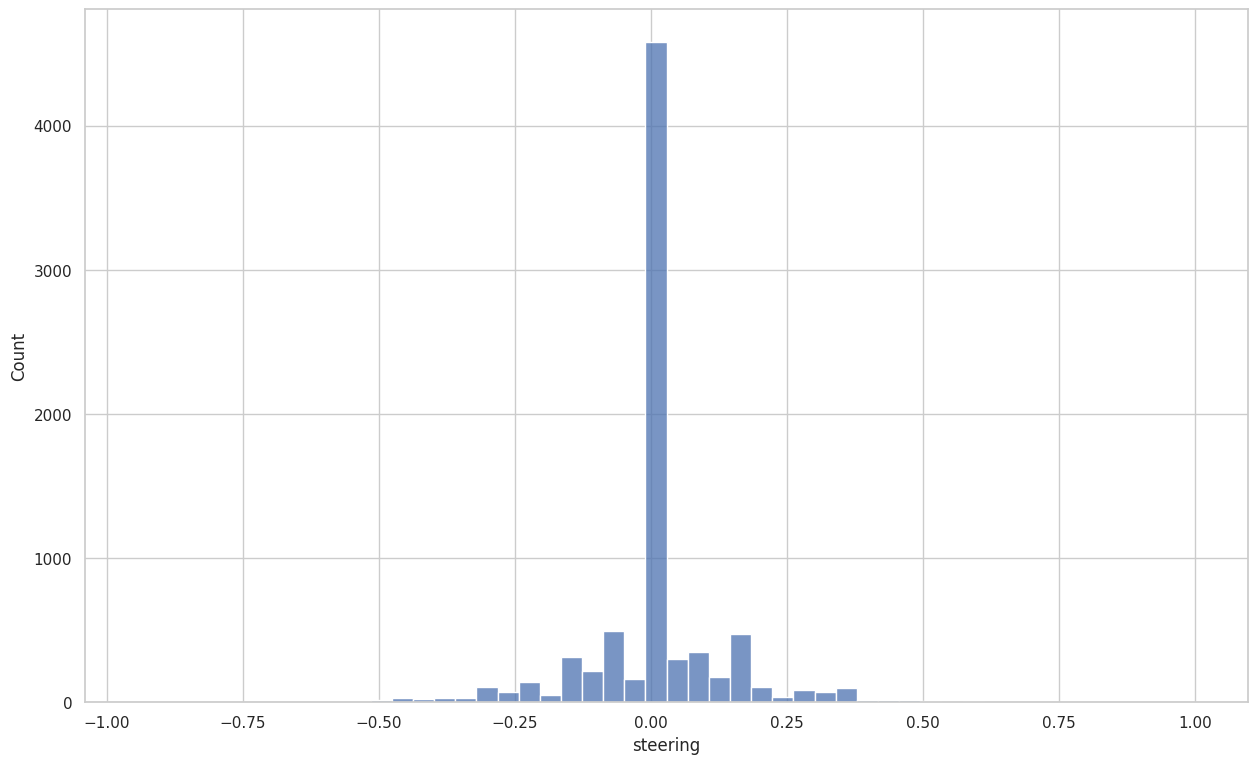

In [15]:
# data["steering"].describe()
# plt.hist(data["steering"])
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'whitegrid')
plt.figure(figsize = (15,9))
sns.histplot(data["steering"], bins = 50)

In [37]:
%pwd

'/content/gdrive/MyDrive'

# Image Preprocessing and Augmentation

In [18]:
import cv2
import numpy as np

def path_to_img(img_path):
    img = cv2.imread(f'data/{img_path}')
    return img

def path_to_img(img_path, angle):
    path = f'data/IMG/{img_path.split("/")[-1]}'
    current_image = cv2.imread(path)[65:-25, :, :]
    # [row_from : row_to, col_from, col_to]

In [35]:
from torchvision import models,transforms,datasets
from torchvision.transforms import v2
from torchvision.io import read_image

def path_to_img(img_path):
  img_path = str(img_path)
  img = read_image(f'data/IMG/{img_path.split("/")[-1]}')
  return img


def random_augment(img, angle):

  if np.random.rand() < 0.5:
    img = cv2.flip(img, 1)
    angle = -angle
  return img, angle

In [23]:
transformations = v2.Compose([
    v2.ToTensor(),  # Convert to tensor, only needed if you had a PIL image
    # v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    # v2.Resize(size=(200,66), antialias=True), # v2.RandomResizedCrop(size=(224, 224), antialias=True)
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# antialias=True to smooth the edges of images or graphics to reduce aliasing artifacts, such as jagged edges or flickering


'''
import torchvision.transforms as transforms
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
'''

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


'\nimport torchvision.transforms as transforms\ntransformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])\n'

# Dataset Reading, Loading and Batching

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

class CarImageDataset(Dataset):
    def __init__(self, samples, transform=None, augment=False):
        self.samples = samples
        self.transform = transform
        self.augment = augment

    def __getitem__(self, index):
        # read-in X and Y
        center_img, left_img, right_img = self.samples[index][:3]
        steering_angle = float(self.samples[index][3])
        # adjust the steering angle based on positions
        angle_center = steering_angle
        angle_left = steering_angle + 0.4
        angle_right = steering_angle - 0.4
        # augment if necessary
        if self.augment:
            center_img, = augment(center_img, steering_angle)
            left_img, = augment(left_img, steering_angle)
            right_img, = augment(right_img, steering_angle)

        return (self.transform(center_img), angle_center), (self.transform(left_img), angle_left), (self.transform(right_img), angle_right)

    def __len__(self):
        return len(self.samples)


In [25]:
dset_train = CarImageDataset(train_samples, transformations)
loader_train = DataLoader(dset_train, batch_size=64, shuffle=True, num_workers=6)
# params = {'batch_size': 32, 'shuffle': True, 'num_workers': 4}
# loader_train = data.DataLoader(dset_train, **params)

dset_valid = CarImageDataset(validation_samples, transformations)
loader_valid = DataLoader(dset_valid, batch_size=64, shuffle=False, num_workers=6)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
# get a batch for plotting
(center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right) = next(iter(loader_valid))

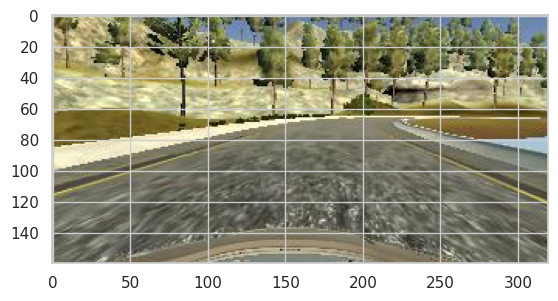

In [46]:
center_img_new = path_to_img(center_img[0])
center_img_new
plt.imshow(np.transpose(center_img_new, (1, 2, 0)))

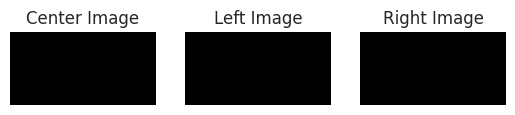

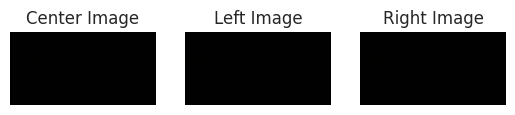

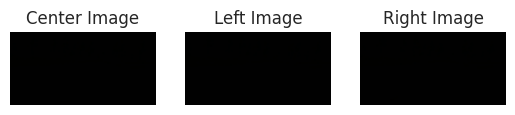

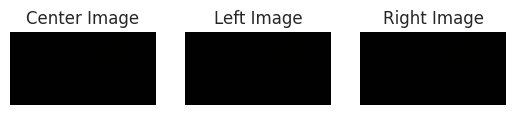

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def imshow(img, title= None):
  img = path_to_img(img)
  img = np.clip(img, 0, 1)
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(title)
  plt.axis('off')

# Visualize the batch of images
for i in range(len(center_img)-60):
    # Display Center Image
    plt.subplot(1, 3, 1)
    imshow(center_img[i], title="Center Image")

    # Display Left Image
    plt.subplot(1, 3, 2)
    imshow(left_img[i], title="Left Image")

    # Display Right Image
    plt.subplot(1, 3, 3)
    imshow(right_img[i], title="Right Image")

    plt.show()

# Model Architecture

 ### NVIDIA Model
    Image normalization to avoid saturation and make gradients work better.
    Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
    Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
    Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
    Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
    Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
    Drop out (0.5)
    Fully connected: neurons: 100, activation: ELU
    Fully connected: neurons: 50, activation: ELU
    Fully connected: neurons: 10, activation: ELU
    Fully connected: neurons: 1 (output)
    
    the convolution layers are meant to handle feature engineering
    the fully connected layer for predicting the steering angle.
    dropout avoids overfitting
    ELU(Exponential linear unit) function takes care of the Vanishing gradient problem.
    
### Simple Model

```
  (module): CarSimpleModel (
    (conv_layers): Sequential (
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): ELU (alpha=1.0)
      (2): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (3): MaxPool2d (size=(4, 4), stride=(4, 4), dilation=(1, 1))
      (4): Dropout (p = 0.25)
    )
    (linear_layers): Sequential (
      (0): Linear (3648 -> 50)
      (1): ELU (alpha=1.0)
      (2): Linear (50 -> 10)
      (3): Linear (10 -> 1)
    )
  )
```

In [ ]:
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

class NetworkDense(nn.Module):

    def __init__(self):
        super(NetworkDense, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, input):
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output


class NetworkLight(nn.Module):

    def __init__(self):
        super(NetworkLight, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 48, 3, stride=2),
            nn.MaxPool2d(4, stride=4),
            nn.Dropout(p=0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*4*19, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )


    def forward(self, input):
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [ ]:
model = NetworkLight()
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

# Training and Validation Loop

In [ ]:
max_epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define lists to track train and valid loss
train_losses = []
valid_losses = []

def to_device(datas, device):
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)

for epoch in range(max_epochs):
    model.to(device)

    # Training
    train_loss = 0
    model.train()
    for local_batch, (centers, lefts, rights) in enumerate(loader_train):
        # Transfer to GPU
        centers, lefts, rights = to_device(centers, device), to_device(lefts, device), to_device(rights, device)

        # Model computations
        optimizer.zero_grad()
        for data in [centers, lefts, rights]:
            imgs, angles = data
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        if local_batch % 100 == 0:
            print(f'Epoch [{epoch+1}/{max_epochs}], Batch [{local_batch+1}], Train Loss: {train_loss/((local_batch+1)*3):.3f}')

    # Track train loss for the epoch
    avg_train_loss = train_loss / ((local_batch + 1) * 3)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for local_batch, (centers, lefts, rights) in enumerate(loader_valid):
            # Transfer to GPU
            centers, lefts, rights = to_device(centers, device), to_device(lefts, device), to_device(rights, device)

            # Model computations
            optimizer.zero_grad()
            for data in [centers, lefts, rights]:
                imgs, angles = data
                outputs = model(imgs)
                loss = criterion(outputs, angles.unsqueeze(1))
                valid_loss += loss.item()

            avg_valid_loss = valid_loss / (local_batch + 1)
            if local_batch % 100 == 0:
                print(f'Epoch [{epoch+1}/{max_epochs}], Validation Batch [{local_batch+1}], Valid Loss: {avg_valid_loss:.3f}')

    # Track validation loss for the epoch
    valid_losses.append(avg_valid_loss)

# Print the final train and validation losses
print("Final Train Loss:", train_losses)
print("Final Validation Loss:", valid_losses)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
Epoch [1/10], Batch [1], Train Loss: 0.769
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch.Size([64, 48, 4, 19])
torch

# Plot Errors

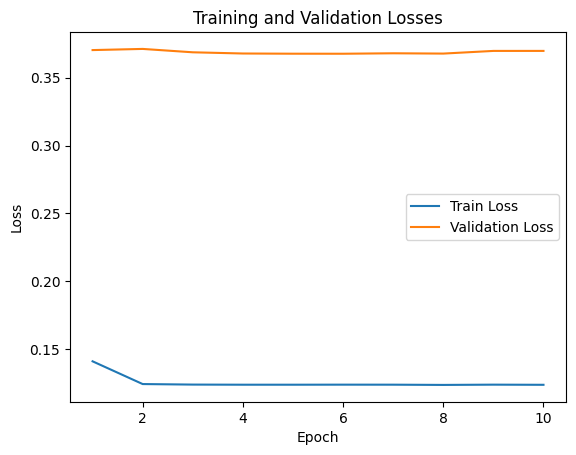

In [ ]:
import matplotlib.pyplot as plt


epochs = range(1, max_epochs + 1)


plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save Model to disk

In [ ]:
state = {
        'model': model.module if device == 'cuda' else model,
        }

torch.save(state, 'model.h5')